# How to build models with limited amount of data

In this kernel we will see how we can get the best results by using only a part of the given data for training.

This dataset contains 25,000 images of dogs and cats (12,500 from each class)

We will pick only 4000 images from this dataset and build our model over it.

In [ ]:
# import libraries
import pandas as pd
import numpy as np

from zipfile import ZipFile 

from sklearn.metrics import precision_score, recall_score, accuracy_score

import os,shutil

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D,Flatten,Dropout
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt

In [ ]:
# unzip given input files
import zipfile

with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/train.zip') as z:
    z.extractall()
    
with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/test.zip') as z:
    z.extractall()

In [ ]:
# load sample submission file
sub = pd.read_csv("../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv")
sub.shape

In [ ]:
sub.head()

## 1) Make Directories

We will create a new dataset containing three subsets: 

* A training set with 1,000 samples of each class(CAT & DOG)
 
* A validation set with 500 samples of each class

In [ ]:
# creating base directory directories
base_dir = './cats_and_dogs_small'
os.mkdir(base_dir)

In [ ]:
# creat sub directories(train,validation and test) under base directory
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [ ]:
# create sub-directories(cats and dogs) under each sub directories(train,validation and test) created above
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [ ]:
# save the path of train and test directories where we saved cats and dogs images after unzipping the input files
original_dataset_train_dir = './train'
original_dataset_test_dir = './test'

In [ ]:
# copy 1000 cats images to "./cats_and_dogs_small/train/cats" sub directory we created above, these images will be used for training the model
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_train_dir, fname) # source folder 
    dst = os.path.join(train_cats_dir, fname) # destination folder
    shutil.copyfile(src, dst) # copying cats images from source to destination folders

In [ ]:
# copy 500 cats images to "./cats_and_dogs_small/validation/cats" sub directory we created above, these images will be used for validing the model
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_train_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
# copy 500 cats images to "./cats_and_dogs_small/test/cats" sub directory we created above, these images will be used for testing the model
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_train_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
# copy 1000 dogs images to "./cats_and_dogs_small/train/dogs" sub directory we created above, these images will be used for training the model
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_train_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
# copy 500 dogs images to "./cats_and_dogs_small/validation/dogs" sub directory we created above, these images will be used for validating the model
fnames = ['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_dataset_train_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
# copy 500 dogs images to "./cats_and_dogs_small/test/dogs" sub directory we created above, these images will be used for testing the model
fnames = ['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_dataset_train_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
# sanity check - lets check the folder where we copied the data has the data as expected
print("train_cats_dir:",len(os.listdir(train_cats_dir)))
print("validation_cats_dir:",len(os.listdir(validation_cats_dir)))
print("test_cats_dir:",len(os.listdir(test_cats_dir)))

print("train_dogs_dir:",len(os.listdir(train_dogs_dir)))
print("validation_dogs_dir:",len(os.listdir(validation_dogs_dir)))
print("test_dogs_dir:",len(os.listdir(test_dogs_dir)))

So we indeed have 2,000 training images, 1,000 validation images. 

Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success. 

## 2) Data preprocessing

To feed the data into a Neural Networks, it should be formatted into appropriately preprocessed floating point tensors.
Currently, our data is in JPEG format, so the steps for getting it into the network are roughly as follows:

* Read the picture files.

* Decode the JPEG content to RGB grids of pixels.

* Convert these into floating-point tensors.

* Rescale the pixel values between 0 and 1 (as you know,neural networks prefer to deal with small input values).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically.

Keras has a module with image-processing helper tools, located at `keras.preprocessing.image`. 

In particular, it contains the class `ImageDataGenerator`, which lets you quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors. This is what we’ll use here.

In [ ]:
# import ImageDataGenerator for pre pro-processing JPEG images as explained above
from keras.preprocessing.image import ImageDataGenerator

# scale pixes between 0 and 1 by dividing the pixes by 255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150, 150),batch_size=20,class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,target_size=(150, 150),batch_size=20,class_mode='binary')

**Let’s look at the output of one of these generators:**

It yields batches of 150 × 150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). 

There are 20 samples in each batch (the batch size). 

Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder.
For this reason, you need to break the iteration loop at some point:

In [ ]:
# since image generators yields bathches indefinitely, we need to break the loop
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

**Before we fit the model to the data using the generator, lets discuss few important points.**

We will use `fit_generator` method to fit the data using generators. 

It expects as its `first argument` a `Python generator` that will yield batches of inputs and targets indefinitely(as discussed above). 

**Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument** 

In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.
 
When using fit_generator, you can pass a validation_data argument, much as with the fit method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. 
 
If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation, let build the model now.

## 3) Model Building

### 3.1) Basic CNN Model

In [ ]:
EPOCH_1 = 1
EPOCH_100 = 100
EPOCH_30 = 30

**You must be already familiar with the following CNN archietechture, if not, you can go through [This Kernel](https://www.kaggle.com/jagdmir/all-you-need-to-know-about-cnns)**.

In [ ]:
# Basic CNN archietechture without Regularization
input_shape = [150,150,3]

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [ ]:
# fitting the model as discussed above
history = model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=EPOCH_30,
            validation_data=validation_generator,
            validation_steps=50)

In [ ]:
# Let’s plot the loss and accuracy of the model over the training and validation data during training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy stalls at 70–72%.

The validation loss reaches its minimum after only five epochs and then stalls, whereas the training loss keeps decreasing linearly until it reaches nearly 0.

Because we have relatively few training samples (2,000), overfitting will be our number-one concern. 
We already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). 

We’re now going to work with a new one, specific to computer vision and used almost universally when processing images with deep-learning models: `data augmentation`

### 3.2) Model with data augmentation(to overcome overfitting)

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. 

Given infinite data, your model Training a convnet from scratch on a small dataset would be exposed to every possible aspect of the data distribution at hand: you would never overfit. 

Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images.

The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model
to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ImageDataGenerator instance. Let’s get started with an example.

In [ ]:
datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation).

**Lets quickly go over this code:** 

* `rotation_range` is a value in degrees (0–180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half the images horizontally—relevant when there are no assumptions of horizontal asymmetry (for example,real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's check augmented images!

In [ ]:
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
plt.figure(figsize = (12,8))

i=0

for batch in datagen.flow(x, batch_size=1):
    plt.subplot(2,2,i+1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If you train a new network using this data-augmentation configuration, the network will never see the same input twice. 

But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. 

As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, you’ll also add a Dropout layer to your model, right before the densely connected classifier.

In [ ]:
# Basic CNN archietechture with Regularization
input_shape = [150,150,3]

model_1 = Sequential()

model_1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.3)) # to overcome overfitting
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.3)) # to overcome overfitting
model_1.add(Dense(1, activation='sigmoid'))

In [ ]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,)

# note, we are not applying these augmentations to the test data
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150, 150),batch_size=32,class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,target_size=(150, 150),batch_size=32,class_mode='binary')

In [ ]:
# compile the model
model_1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [ ]:
history = model_1.fit_generator(
            train_generator,
            steps_per_epoch=63,            
            epochs = EPOCH_100,
            validation_data=validation_generator,
            validation_steps=32)

In [ ]:
# Let’s plot the loss and accuracy of the model over the training and validation data during training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

By using regularization techniques even further, and by tuning the network’s parameters (such as the number of filters per convolution layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86% or 87%.

But it would prove difficult to go any higher just by training your own convnet from scratch, because we have so little data to work with. As a next step to improve your accuracy on this problem, we will use a pretrained model.

### 3.3) Model Using a pretrained convnet(VGG16)
A common and highly effective approach to deep learning on small image datasets is to use a `pretrained network`. 

A pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image
classification task. 

If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computervision problems, even though these new problems may involve completely different classes than those of the original task. 

For instance, you might train a network on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained network for something as remote as identifying furniture items in images. 

Such portability of learned features across different problems is a key advantage of deep learning compared to many older, shallow-learning approaches, and it makes deep learning very effective for small-data problems.
 
In this case, let’s consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect to
perform well on the dogs-versus-cats classification problem.

We’ll use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014; it’s a simple and widely used convnet architecture for ImageNet.

There are two ways to use a pretrained network: feature extraction and fine-tuning. We’ll cover both of them in this notebook. 

Let’s start with feature extraction.

#### 3.3.1) Feature extraction 

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As you saw previously, convnets used for image classification comprise two parts:

**Part-1:** They start with a series of pooling and convolution layers.This part is called the convolutional base of the model.

**Part-2:** They end with a densely connected classifier.  

In the case of convnets, feature extraction consists of taking the convolutional base of apreviously trained network, running the new data through it, and training a new classifier on top of the output(see figure below)

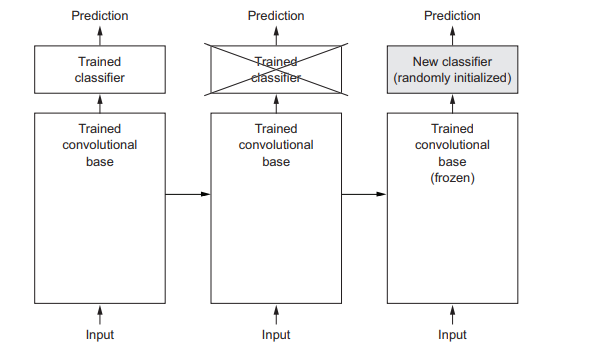

Why only reuse the convolutional base? Could you reuse the densely connected classifier as well? 

In general, doing so should be avoided. The reason is that the representations learned by the convolutional base are likely to be more generic and therefore more reusable whereas the representations learned by the classifier will necessarily be specific to the
set of classes on which the model was trained.  

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. 

Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”). 

So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In this case, because the ImageNet class set contains multiple dog and cat classes, it’s likely to be beneficial to reuse the information contained in the densely connected layers of the original model. 

But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the original model. 

Let’s put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.

The VGG16 model, among others, comes prepackaged with Keras. You can import it from the keras.applications module. Here’s the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of keras.applications:

* Xception
* Inception V3
* ResNet50
* VGG16
* VGG19
* MobileNet
* 
Let’s instantiate the VGG16 model.

In [ ]:
# lets import VGG16 pre-trained model
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

We passed three arguments to the constructor:

1) `weights` specifies the weight checkpoint from which to initialize the model.

2) `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because we intend to use our own densely connected classifier (with only two classes: cat and dog), we don’t need to include it.

3) `input_shape` is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if we don’t pass it, the network will be able to process inputs of any size.

Here’s the detail of the architecture of the VGG16 convolutional base. It’s similar to the simple convnets you’re already familiar with:

In [ ]:
conv_base.summary()

The final feature map has shape (4, 4, 512). That’s the feature on top of which you’ll stick a densely connected classifier.

At this point, there are two ways we could proceed:

1) Running the convolutional base over our dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier, This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.

2) Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data. This will allow you to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first

We’ll discuss both the techniques here!

#### 3.3.2) FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

We’ll start by running instances of the previously introduced ImageDataGenerator to extract images as Numpy arrays as well as their labels. We’ll extract features from these images by calling the predict method of the conv_base model.

In [ ]:
#base_dir = '/Users/fchollet/Downloads/cats_and_dogs_small'
#train_dir = os.path.join(base_dir, 'train')
#validation_dir = os.path.join(base_dir, 'validation')
#test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,target_size=(150, 150),batch_size=batch_size,class_mode='binary')
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192):

In [ ]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))

At this point, we can define our densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that we just recorded.

In [ ]:
# Densly Connected Classifier
model = keras.models.Sequential()
model.add(keras.layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
# compile the model
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])

In [ ]:
# fit the model on the features extracted
history = model.fit(train_features, train_labels,epochs=EPOCH_30,batch_size=20,validation_data=(validation_features, validation_labels))

Training is very fast, because we only have to deal with two Dense layers

In [ ]:
# plotting the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We reached a validation accuracy of about 90%—much better than we achieved earlier with the small model trained from scratch. 

But the plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large
rate

That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets. 

#### 3.3.2) FEATURE EXTRACTION WITH DATA AUGMENTATION

Now, let’s review the second technique we mentioned for doing feature extraction,which is much slower and more expensive, but which allows us to use data augmentation during training: extending the conv_base model and running it end to end on the inputs.

Because models behave just like layers, you can add a model (like conv_base) to a Sequential model just like you would add a layer.

In [ ]:
#  Adding a densely connected classifier on top of the convolutional base
model = keras.models.Sequential()
model.add(conv_base) # adding pre-trained conv base model
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

As we can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we’re adding on top has 2 million parameters.

Before we compile and train the model, it’s very important to freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. 

If we don’t do this, then the representations that were previously learned by the convolutional base will be modified during training,because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, we can freeze a network by setting its trainable attribute to False. Let's check how to do it!

In [ ]:
 print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

In [ ]:
# freezing the layers of pre-trained model
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

With this setup, only the weights from the two Dense layers that we added will be trained. That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector). 

Note that in order for these changes to take effect, we must first compile the model. 

If we ever modify weight trainability after compilation, we should then recompile the model, or these changes will be ignored.
 
Now you can start training your model, with the same data-augmentation configuration that we used in the previous example.

In [ ]:
#  Training the model end to end with a frozen convolutional base
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150, 150),
                    batch_size=20,
                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,target_size=(150, 150),batch_size=20,class_mode='binary')

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])

In [ ]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=EPOCH_30,
            validation_data=validation_generator,
            validation_steps=50)

Let’s plot the results again. 

Great, we reached a validation accuracy of about 90%. This is much better than we achieved with the small convnet trained from scratch.

In [ ]:
# plotting the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 3.3.2) Fine Tuning

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning (see figure below). 

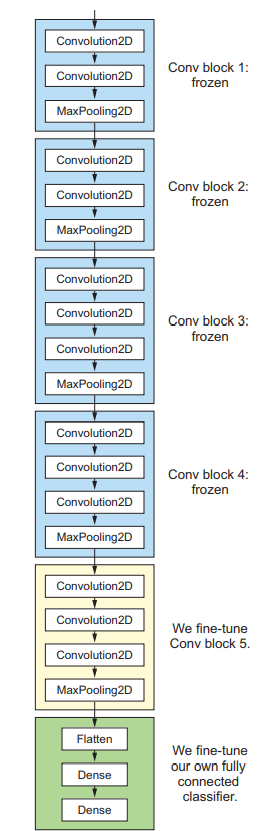

Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training
both the newly added part of the model (in this case, the fully connected classifier) and these top layers. 

This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

As stated earlier that it’s necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. 

For the same reason, it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top
has already been trained. If the classifier isn’t already trained, then the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. 

Thus the steps for fine-tuning a network are as follow:

* Add custom network on top of an already-trained base network.
* Freeze the base network.
* Train the part you added.
* Unfreeze some layers in the base network.
* Jointly train both these layers and the part you added.

We already completed the first three steps when doing feature extraction. 

Let’s proceed with step 4: unfreeze conv_base and then freeze individual layers inside it.


We’ll fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers 
block5_conv1, block5_conv2, and block5_conv3 should be trainable.
 
**Why not fine-tune more layers? Why not fine-tune the entire convolutional base?**

We could. But we need to consider the following:

Earlier layers in the convolutional base encode more-generic, reusable features,whereas layers higher up encode more-specialized features. 

It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.

The more parameters we’re training, the more we’re at risk of overfitting.

The convolutional base has 15 million parameters, so it would be risky to attempt to train it on our small dataset.

Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base. 

Let’s set this up, starting from where we left off in the previous example.

In [ ]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can begin fine-tuning the network. 

We’ll do this with the RMSProp optimizer, using a very low learning rate. The reason for using a low learning rate is that
we want to limit the magnitude of the modifications we make to the representations of the three layers we’re fine-tuning. 

Updates that are too large may harm these representations.

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-5),metrics=['acc'])

history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=EPOCH_100,validation_data=validation_generator,validation_steps=50)

In [ ]:
# plotting the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We have 93% accuracy now, which is way better than the model that we build from scratch.

In the next version of this notebook, we will make predictions on the test dataset!